In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.datasets import co2

from datadata import utils
from prevision import addDates

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df_sales=pd.read_csv("prevision/data/daily_sales.csv",parse_dates=['Date'] ,index_col='Date').rename_axis('date')
df_meteo=pd.read_csv("prevision/data/meteo.csv",parse_dates=['time'],index_col='time').rename_axis('date').drop('Unnamed: 0',axis=1)
df_predictHQ=pd.read_csv("prevision/data/affluence.csv",parse_dates=['date'],index_col='date')
df_all=pd.merge(pd.merge(df_sales, df_meteo, on='date'), df_predictHQ, on='date').reset_index().dropna()
df_all=addDates(df_all)

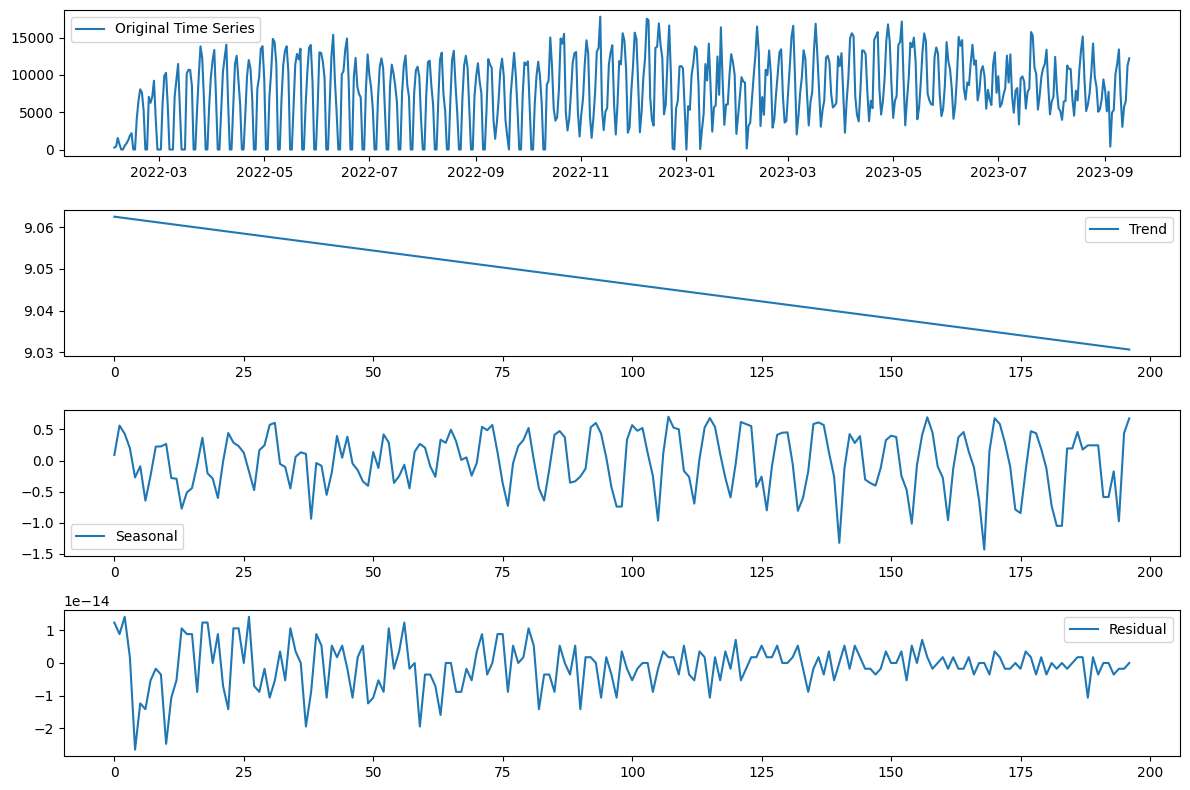

In [3]:
sales_data_non_zero = df_all['vente'].replace(0, np.nan).dropna()
log_sales = np.log(sales_data_non_zero)
stl = STL(log_sales, seasonal=13,period=30*6)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series and the components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df_sales['vente'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
class WindowGenerator():
    def __init__(self, X, Y, input_sequence_length=14, output_sequence_length=7):
        self.X=X
        self.Y=Y
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        
        assert (len(self.X) - self.input_sequence_length - self.output_sequence_length + 1 > 0), \
            f'Dataset size too small for current options\ndata:{len(self.X)}, ' \
            f'input_sequence_length:{input_sequence_length}, output_sequence_length:{output_sequence_length}'

    def __len__(self):  # number of windows we can generate to work it must be at least 1
        return len(self.X) - self.input_sequence_length - self.output_sequence_length + 1

    def __getitem__(self, idx):
        x=np.concatenate(
            (self.X[idx:idx + self.input_sequence_length], self.Y[idx:idx + self.input_sequence_length][:, None]),1)
        y = self.Y[
            idx + self.input_sequence_length:idx + self.input_sequence_length + self.output_sequence_length]
        return x, y

def split_data_based_on_duration(data, duration_months):
    last_date = data['date'].max()
    cutoff_date = last_date - pd.DateOffset(months=duration_months)
    train_data = data[data['date'] <= cutoff_date]
    validation_data = data[data['date'] > cutoff_date]
    return train_data, validation_data

def getXY(data,input_sequence_length=14, output_sequence_length=7):
    x=data.drop(['date','vente'],axis=1).values
    y=data['vente'].values
    win=WindowGenerator(x,y,input_sequence_length, output_sequence_length)
    newX=[]
    newY=[]
    for i in range(len(win)):
        newX.append(win[i][0].flatten('F'))
        newY.append(win[i][1])
    return newX,newY
    
def plot_eval_result(eval_results):
    # Extract training and validation losses
    train_loss = eval_results['validation_0']['rmse']
    val_loss = eval_results['validation_1']['rmse']

    # Plot the loss
    epochs = len(train_loss)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Validation RMSE: 2518.3123364709077
best params
 subsample n_estimators max_depth learning_rate colsample_bytree


/Users/carlos/PycharmProjects/dionysos/venv/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


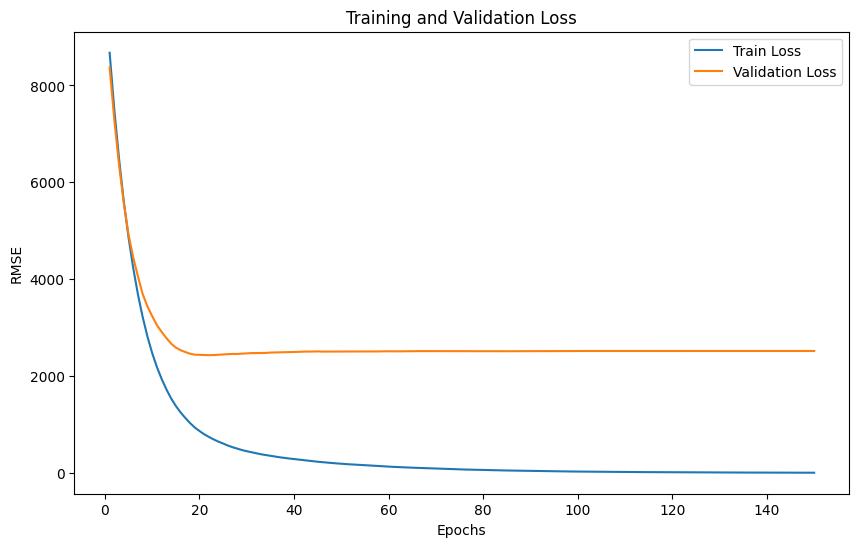

In [5]:
sales_data=df_all
train_data_1yr, validation_data_1yr = split_data_based_on_duration(sales_data, 12)
train_data_6mo, validation_data_6mo = split_data_based_on_duration(sales_data, 6)
train_data_3mo, validation_data_3mo = split_data_based_on_duration(sales_data, 3)

train_data_1yr.reset_index(drop=True, inplace=True)
validation_data_1yr.reset_index(drop=True, inplace=True)
train_data_6mo.reset_index(drop=True, inplace=True)
validation_data_6mo.reset_index(drop=True, inplace=True)
train_data_3mo.reset_index(drop=True, inplace=True)
validation_data_3mo.reset_index(drop=True, inplace=True)

input_sequence_length=14
output_sequence_length=7
X_train,Y_train=getXY(train_data_3mo)
X_test,Y_test=getXY(validation_data_3mo)

param_space = {
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting rounds
    'max_depth': np.arange(3, 10),  # Maximum depth of the tree
    'learning_rate': np.arange(0.05, 0.31, 0.05),  # Learning rate
    'subsample': np.arange(0.7, 1.0, 0.1),  # Subsample ratio
    'colsample_bytree': np.arange(0.7, 1.0, 0.1),  # Subsample ratio of columns
}
xgb_regressor = xgb.XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_space,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=3,
                                   random_state=42, verbose=1, n_jobs=-1)

random_search.fit(X_train, Y_train)
best_model = random_search.best_estimator_
val_preds = best_model.predict(X_test)
val_rmse = np.sqrt(mean_squared_error(Y_test, val_preds))
print('Validation RMSE:', val_rmse)
print('best params\n',*random_search.best_params_)

best_model.fit(X_train, Y_train,
               eval_set=[(X_train, Y_train), (X_test, Y_test)],
               eval_metric='rmse',
               verbose=0)
eval_results = best_model.evals_result()
res = best_model.predict(X_test)
plot_eval_result(eval_results)


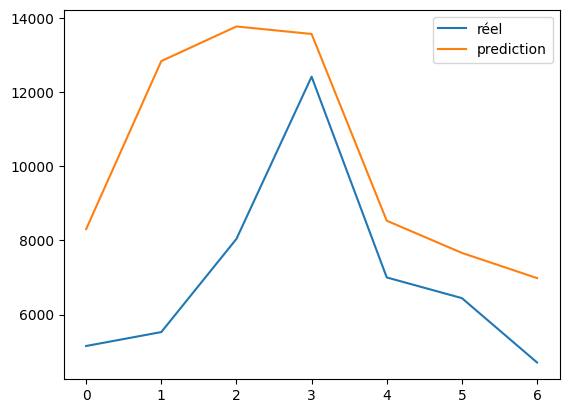

In [6]:
plt.plot(Y_test[0],label='réel')
plt.plot(res[0],label='prediction')
plt.legend()
plt.show()


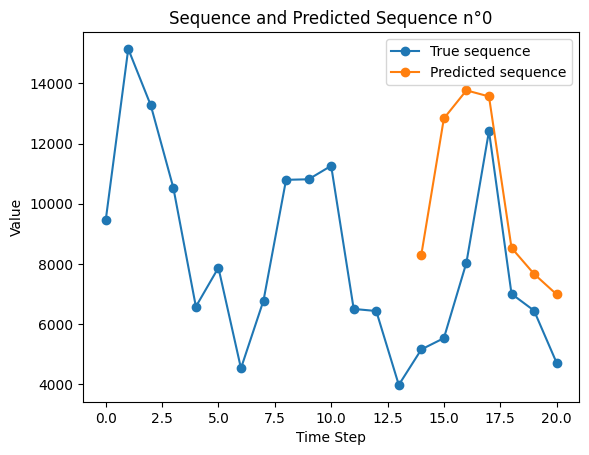

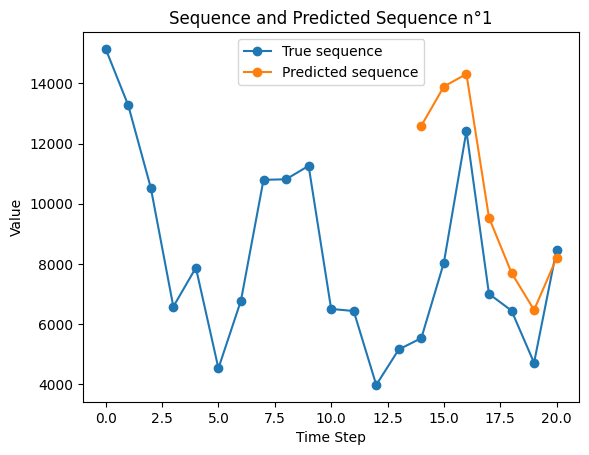

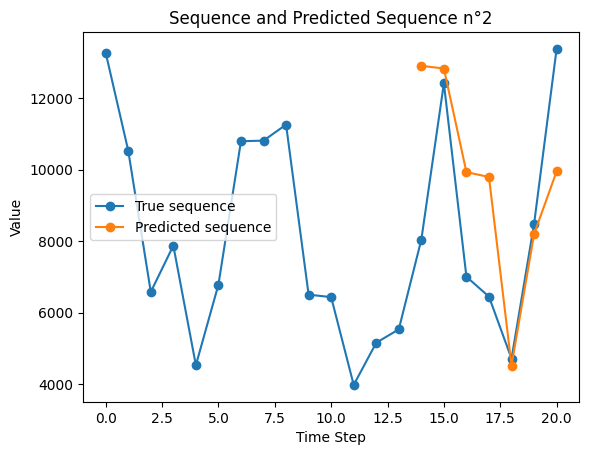

In [7]:
ntest=3
for i in range(ntest):
    history_sequence=X_test[i][-input_sequence_length:]
    target_sequence=Y_test[i]
    predicted_sequence=res[i]
    plt.plot(range(input_sequence_length + output_sequence_length),
        np.concatenate((history_sequence, target_sequence)), label='True sequence',
        linestyle="-", marker="o")
    plt.plot(range(input_sequence_length, input_sequence_length + output_sequence_length),
        predicted_sequence, linestyle="-", marker="o", label='Predicted sequence')
    plt.legend()
    plt.title(f'Sequence and Predicted Sequence n°{i}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()